# <font color="red">Big Mart Sales Problem</font>

In [25]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer,OneHotEncoder,PolynomialFeatures,LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,learning_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import OLS
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

In [26]:
train=pd.read_csv("D:/Learning Materials/Data Science projects/Bigmart Sales Data/train.csv")
test=pd.read_csv("D:/Learning Materials/Data Science projects/Bigmart Sales Data/Test.csv")
submission=pd.read_csv("D:/Learning Materials/Data Science projects/Bigmart Sales Data/Submission.csv")
del submission["Item_Outlet_Sales"]

In [27]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [28]:
#train.count()

In [29]:
#train.describe()

In [30]:
#train.groupby("Item_Type")["Item_Visibility"].mean()

In [31]:
#train.Item_Type[train.Item_Visibility==0].value_counts()

# Data Preprocessing

### Feature Engineering

In [32]:
new=np.array([])
for i in range(8523):
    if train["Item_Identifier"][i][:2]=='FD':
        new=np.append(new,"Food Drink")
    elif train["Item_Identifier"][i][:2]=='NC':
        new=np.append(new,"Non Consumable")
    elif train["Item_Identifier"][i][:2]=='DR':
        new=np.append(new,"Drink")
train["Item_Identifier"]=pd.DataFrame(new)

In [33]:
new=np.array([])
for i in range(5681):
    if test["Item_Identifier"][i][:2]=='FD':
        new=np.append(new,"Food Drink")
    elif test["Item_Identifier"][i][:2]=='NC':
        new=np.append(new,"Non Consumable")
    elif test["Item_Identifier"][i][:2]=='DR':
        new=np.append(new,"Drink")
test["Item_Identifier"]=pd.DataFrame(new)

C:\Users\HOME\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Item Visibility Distribution')

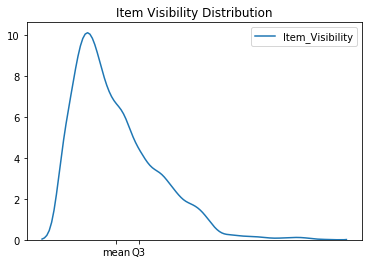

In [34]:
sns.kdeplot(train.Item_Visibility)
plt.xticks([0.066132,0.094585],["mean","Q3"])
plt.title("Item Visibility Distribution")

In [35]:
#train.isnull().any()
train["Item_Visibility"]=train["Item_Visibility"].replace(0,0.068513)
test["Item_Visibility"]=test["Item_Visibility"].replace(0,0.068513)

### Replacing Duplicate Values

In [36]:
train.iloc[:,2]=train.iloc[:,2].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'})
test.iloc[:,2]=test.iloc[:,2].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'})

In [37]:
train.Item_Fat_Content[train["Item_Identifier"]=='Non Consumable']='Unknown'
test.Item_Fat_Content[test["Item_Identifier"]=='Non Consumable']='Unknown'

C:\Users\HOME\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\HOME\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Changing Year Column

In [38]:
train["Outlet_Establishment_Year"]=2013-train["Outlet_Establishment_Year"]
test["Outlet_Establishment_Year"]=2013-test["Outlet_Establishment_Year"]

In [39]:
train["Outlet_Size"]=train["Outlet_Size"].fillna("Small")
test["Outlet_Size"]=test["Outlet_Size"].fillna("Small")
train["Item_Weight"]=train["Item_Weight"].fillna(train["Item_Weight"].mean())
test["Item_Weight"]=test["Item_Weight"].fillna(test["Item_Weight"].mean())

### Label Encoding

In [40]:
train_pop=pd.concat([train.pop(x) for x in ["Item_Type","Item_Fat_Content",
                                            "Outlet_Size","Outlet_Location_Type","Outlet_Type",
                                            "Outlet_Identifier","Item_Identifier"]],axis=1)
#train_pop.head()

In [41]:
test_pop=pd.concat([test.pop(x) for x in ["Item_Type","Item_Fat_Content",
                                          "Outlet_Size","Outlet_Location_Type","Outlet_Type",
                                          "Outlet_Identifier","Item_Identifier"]],axis=1)
#test_pop.head()

In [42]:
labelencoder=LabelEncoder()
#train_pop["Item_Fat_Content"]=labelencoder.fit_transform(train_pop["Item_Fat_Content"])
train_pop["Item_Type"]=labelencoder.fit_transform(train_pop["Item_Type"])
train_pop["Item_Fat_Content"]=labelencoder.fit_transform(train_pop["Item_Fat_Content"])
train_pop["Outlet_Size"]=labelencoder.fit_transform(train_pop["Outlet_Size"])
train_pop["Outlet_Location_Type"]=labelencoder.fit_transform(train_pop["Outlet_Location_Type"])
train_pop["Outlet_Type"]=labelencoder.fit_transform(train_pop["Outlet_Type"])
train_pop["Outlet_Identifier"]=labelencoder.fit_transform(train_pop["Outlet_Identifier"])
train_pop["Item_Identifier"]=labelencoder.fit_transform(train_pop["Item_Identifier"])

In [43]:
#test_pop["Item_Fat_Content"]=labelencoder.fit_transform(test_pop["Item_Fat_Content"])
test_pop["Item_Type"]=labelencoder.fit_transform(test_pop["Item_Type"])
test_pop["Item_Fat_Content"]=labelencoder.fit_transform(test_pop["Item_Fat_Content"])
test_pop["Outlet_Size"]=labelencoder.fit_transform(test_pop["Outlet_Size"])
test_pop["Outlet_Location_Type"]=labelencoder.fit_transform(test_pop["Outlet_Location_Type"])
test_pop["Outlet_Type"]=labelencoder.fit_transform(test_pop["Outlet_Type"])
test_pop["Outlet_Identifier"]=labelencoder.fit_transform(test_pop["Outlet_Identifier"])
test_pop["Item_Identifier"]=labelencoder.fit_transform(test_pop["Item_Identifier"])

In [44]:
test_pop.head()

,Item_Type,Item_Fat_Content,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Identifier,Item_Identifier
0,13,0,1,0,1,9,1
1,4,1,2,1,1,2,1
2,11,2,2,2,0,0,2
3,13,0,2,1,1,2,1
4,4,1,1,2,3,5,1


### One Hot Encoding

In [45]:
for i in range(1,8):
    onehotencoder=OneHotEncoder(categorical_features=[-1])
    z=onehotencoder.fit_transform(train_pop).toarray()
    train_pop=pd.DataFrame(z)
    train_pop=train_pop.iloc[:,1:]
#train_pop.head()

C:\Users\HOME\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\HOME\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:385: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)
C:\Users\HOME\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integ

In [46]:
for i in range(1,8):
    onehotencoder=OneHotEncoder(categorical_features=[-1])
    z=onehotencoder.fit_transform(test_pop).toarray()
    test_pop=pd.DataFrame(z)
    test_pop=test_pop.iloc[:,1:]
#test_pop.head()

C:\Users\HOME\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\HOME\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:385: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)
C:\Users\HOME\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integ

### <font color='maroon'>Creating New Dataset After Encoding<font>

In [47]:
train_new=pd.concat([train_pop,train],axis=1)
test_new=pd.concat([test_pop,test],axis=1)

In [48]:
x=train_new.iloc[:,:-1].values
y=train_new.iloc[:,-1:].values

### Train-Test Split

In [49]:
x_train,x_test,y_train,y_test=train_test_split(x,y.ravel(),test_size=0.20,random_state=0)

# <font color='red'>Random Forest Regression<font>

In [50]:
forest=RandomForestRegressor(n_estimators=500,random_state=0,max_depth=5,min_samples_leaf=10,
                             min_samples_split=2,min_weight_fraction_leaf=0.01)
forest.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.01, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

### Checking my model on x_test

In [51]:
r2_score((y_test),(forest.predict(x_test)))

0.5919699073117649

In [52]:
np.sqrt(mean_squared_error(y_test,forest.predict(x_test)))

1092.815965215243

# Cross-Validation

In [53]:
def cross_validation(estimator):
    accuracies=cross_val_score(estimator,X=x_train,y=y_train,scoring='neg_mean_squared_error',cv=10)
    return np.sqrt(-accuracies.mean())

In [54]:
cross_validation(estimator=forest)

1079.114143924435

# Grid Search For Random Forest Algorithm

In [203]:
parameter=[{'max_depth':[5],'max_features':['auto'],'min_samples_leaf':[10],
            'min_samples_split':[2],
           'min_weight_fraction_leaf':[0.01]}]
grid=GridSearchCV(estimator=forest,
                 param_grid=parameter,
                 scoring='neg_mean_squared_error',
                 cv=10)
grid=grid.fit(x_train,y_train)

In [204]:
np.sqrt(-grid.best_score_),grid.best_params_

(1079.0509330000232,
 {'max_depth': 5,
  'max_features': 'auto',
  'min_samples_leaf': 10,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.01})

# Test Set Prediction

In [206]:
test_pred=xgb.predict(test_new.values)
test_pred=pd.DataFrame(test_pred,columns=["Item_Outlet_Sales"])

In [207]:
submission=pd.concat([submission,test_pred],axis=1)

In [208]:
#submission

In [209]:
submission.to_csv("Bigmart_Submission.csv")

# Learning Curve



In [30]:
import sys
sys.setrecursionlimit(1500)

In [106]:
train_size=[1,100,500,1000,2000,5454]

In [107]:
def learning_curves(estimator,X,y,train_sizes,cv):
    sns.set_style("darkgrid")
    plt.figure(figsize=(16,8))
    train_size=[1,100,500,1000,2000,5454]
    train_size,train_scores,test_scores=learning_curve(estimator,X,y,train_sizes=train_sizes,
                                                    cv=cv,scoring="neg_mean_squared_error",shuffle=True)
    train_scores_mean=np.sqrt(-train_scores.mean(axis=1))
    test_scores_mean=np.sqrt(-test_scores.mean(axis=1))
    plt.plot(train_size,train_scores_mean,label="Training Error",color="red")
    plt.plot(train_size,test_scores_mean,label="Validation Error")
    plt.xlabel("Training size")
    plt.ylabel("MSE")
    plt.xticks([0,100,1000,2000,5000])
    plt.yticks([0,500,1000,1092,1150,2000])
    plt.title("Learning Curve For Random Forest Regressor")
    plt.legend()
    plt.ylim(0,2000)

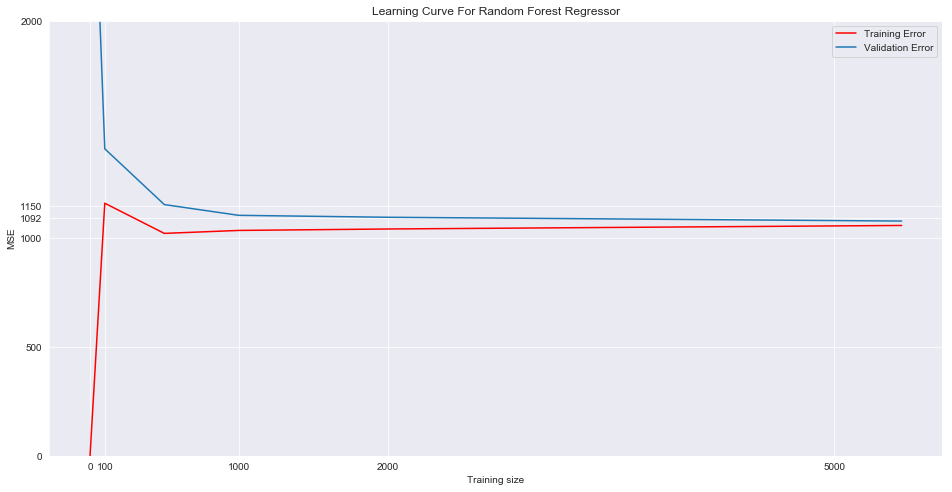

In [108]:
learning_curves(estimator=forest,
                X=x_train,y=y_train,train_sizes=train_size,
                cv=5)

> The Model Has Relatively High Bias And Low Variance

> So It's Not Helpful to Add More Data points

# XGBoost

In [100]:
xgb=XGBRegressor(n_estimators=10,gamma=0,
                 max_depth=3,learning_rate=0.5,
                 min_child_weight=5,max_delta_step=0,
                reg_lambda=2,
                reg_alpha=0.3)
xgb.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=3, min_child_weight=5, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.3, reg_lambda=2, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [101]:
np.sqrt(mean_squared_error(y_train,xgb.predict(x_train)))

1057.1082357596463

In [102]:
np.sqrt(mean_squared_error(y_test,xgb.predict(x_test)))

1094.5913337341417

In [103]:
r2_score((y_test),(xgb.predict(x_test)))

0.5906430741928085

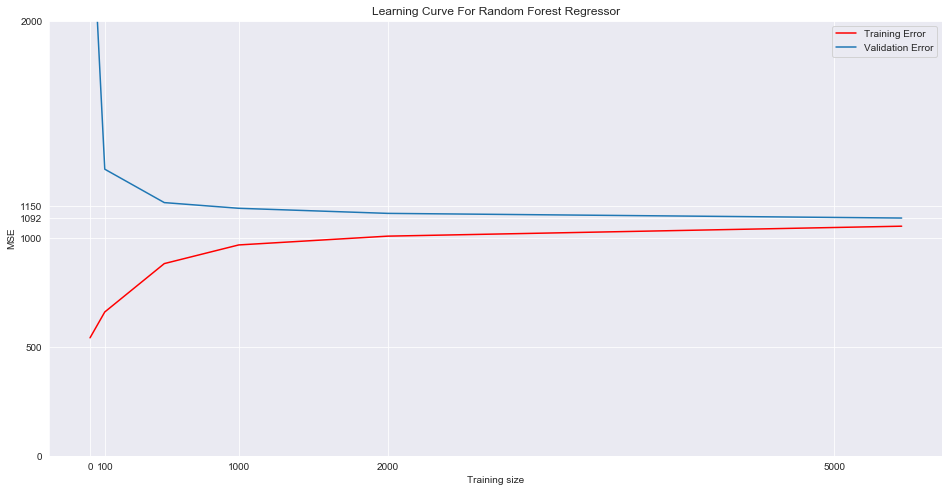

In [179]:
learning_curves(estimator=xgb,X=x_train,y=y_train,train_sizes=train_size,cv=5)

In [ ]:
base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.071, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


# Grid Search

In [109]:
parameter=[{'n_estimators':[10,9],'gamma':[0],'learning_rate':[0.5,0.7],
            'max_depth':[3,4,2],'min_child_weight':[3],'reg_lambda':[2,3],
           'max_delta_step':[0],'reg_alpha':[0.3],
           'colsample_bylevel':[1,0.8,0.7],'colsample_bytree':[1,0.8,0.9]}]
grid=GridSearchCV(estimator=xgb,
                 param_grid=parameter,
                 scoring='neg_mean_squared_error',
                 cv=10)
grid=grid.fit(x_train,y_train)

In [110]:
np.sqrt(-grid.best_score_),grid.best_params_

(1087.0605601612522,
 {'colsample_bylevel': 1,
  'colsample_bytree': 0.9,
  'gamma': 0,
  'learning_rate': 0.5,
  'max_delta_step': 0,
  'max_depth': 3,
  'min_child_weight': 3,
  'n_estimators': 10,
  'reg_alpha': 0.3,
  'reg_lambda': 2})